In [70]:
#Short term fluctuations
!pip install pandas_datareader
!pip install yfinance
!pip install xgboost
!pip install ta
import ta
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import xgboost as xgb
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'
import yfinance as yfin
yfin.pdr_override()

In [71]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()

In [72]:
#dataframe for reading selected stock (Googl(the ticker name), (yahoo api))
#df = web.DataReader('GOOGL','yahoo',start,end)
df = pdr.get_data_yahoo("GOOGL", start="2013-01-01", end=datetime.datetime.now())
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,18.003504,18.193193,17.931683,18.099348,18.099348,101550348
2013-01-03,18.141392,18.316566,18.036036,18.109859,18.109859,92635272
2013-01-04,18.251753,18.555305,18.210211,18.467718,18.467718,110429460
2013-01-07,18.404655,18.503002,18.282784,18.387136,18.387136,66161772
2013-01-08,18.406906,18.425926,18.128880,18.350851,18.350851,66976956
...,...,...,...,...,...,...
2023-05-26,123.169998,125.260002,122.449997,124.610001,124.610001,35635900
2023-05-30,125.639999,125.660004,122.000000,123.669998,123.669998,35076700
2023-05-31,122.750000,124.059998,122.500000,122.870003,122.870003,37325800


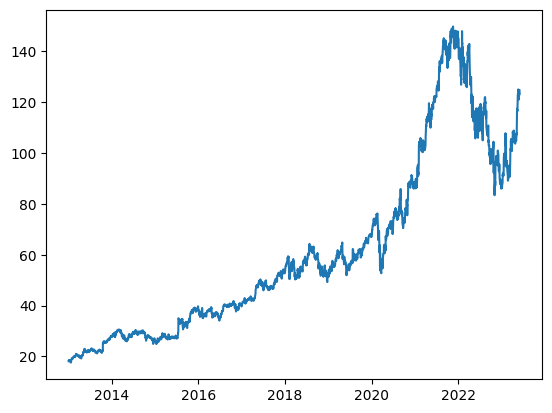

In [73]:
#Plot the closing price of Google (or whichever one)
plt.plot(df['Close'])

In [74]:
#Perform classification decision trees (buy or sell) = binary classification 
#Add a column takes the closing price (pct_change) = moving avg for 60 days in the future
#When I didn't make it avg for the future(1,-1), precision is decreased
#But too high and I just realized I'm overfitting (i think check this later)
df['Return'] = df['Adj Close'].pct_change(60).shift(-60)
# Relative Strength Index basically means that
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
df['SMA'] = df['Close'].rolling(window=20).mean()  # Moving Average basically means that 

df['MACD'] = ta.trend.MACD(df['Close']).macd()   # Moving Average Convergence Divergence basically means that

# Add additional features to the feature list
list_of_features = ['High', 'Low', 'Close', 'Volume', 'Adj Close', 'SMA', 'RSI', 'MACD']
#feed all features except Open cause precision decreased
X = df[list_of_features]
#X.tail()
#Look for values where the return is positive, if = 1, else = 0
y = np.where(df.Return > 0, 1, 0)
#df

In [75]:
#split data to see how good the decision tree will be
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 500)
#print sizes of the data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1836, 8)
(787, 8)
(1836,)
(787,)


In [76]:
#treeClassifier = DecisionTreeClassifier('entropy', max_depth=4, min_samples_leaf=7)
#treeClassifier.fit(X_train, y_train)
xgb_Classifier = xgb.XGBClassifier(max_depth=3)
xgb_Classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [77]:
#y_pred = tree_Classifier.predict(X_test)
y_pred = xgb_Classifier.predict(X_test)

In [78]:
#Check performances
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print(report)
#Conc. XGB provides better precision, from study i might say it's due to it being able to take out an unnecessary branches preventing
#overfitting or it may be due to the regularization techniques said in the notes that control the complexity of the trees
#Also prob simply how XGB works in terms of Gradient boosting by cutting out the errors from previous models to make new ones
#(Check all of these with someone more knowledgeable)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       312
           1       0.86      0.92      0.89       475

    accuracy                           0.86       787
   macro avg       0.86      0.85      0.85       787
weighted avg       0.86      0.86      0.86       787



<Figure size 2400x5000 with 0 Axes>

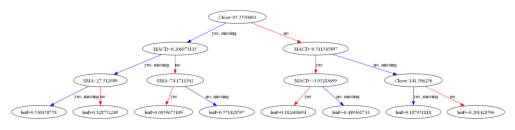

In [79]:
#View Tree
from sklearn import tree
import graphviz
#data = tree.export_graphviz(xgb_Classifier, filled=True, feature_names=list_of_features,class_names=np.array(['0', '1']))
#graphviz.Source(data)
#gb.plot_tree(xgb_Classifier)
#plt.show()

#dot_data = xgb.to_graphviz(xgb_Classifier, num_trees=0, rankdir='UT', filled=True, feature_names=list_of_features, class_names=['0', '1'])
#graph = graphviz.Source(dot_data)
#graph.render("decision_tree")  # Save the decision tree visualization as a PDF file
plt.figure(figsize=(24, 50))
# Visualize a single tree using xgb.plot_tree()
xgb.plot_tree(xgb_Classifier, num_trees=0, max_depth=3)
plt.show()